Course: WI4011-17 Computational Fluid Dynamics

Author: Bradley van Hoof, Leonardo Alessandro Lüder, Rosa Calegari

Academic year: 2023/2024

Delft University of Technology

In [715]:
import numpy
import scipy.sparse
import scipy.linalg
from matplotlib import pyplot as plt

In [716]:
def generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y):
    
    n_vertices_x = n_cells_x + 1
    n_vertices_y = n_cells_y + 1
    n_cells = n_cells_x * n_cells_y

    x, y = numpy.meshgrid(numpy.linspace(x_min, x_max, n_vertices_x), numpy.linspace(y_min, y_max, n_vertices_y))
    vertices = numpy.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])

    cells = numpy.zeros([n_cells, 4], dtype=numpy.int64)
    for j in range(0, n_cells_y):
        for i in range(0, n_cells_x):
            k = i + n_cells_x*j  

            cells[k, 0] = (i) + (n_cells_x + 1)*(j)  # the linear index of the lower left corner of the element
            cells[k, 1] = (i+1) + (n_cells_x + 1)*(j)  # the linear index of the lower right corner of the element
            cells[k, 2] = (i) + (n_cells_x + 1)*(j+1)  # the linear index of the upper left corner of the element
            cells[k, 3] = (i+1) + (n_cells_x + 1)*(j+1)  # the linear index of the upper right corner of the element

    return vertices, cells

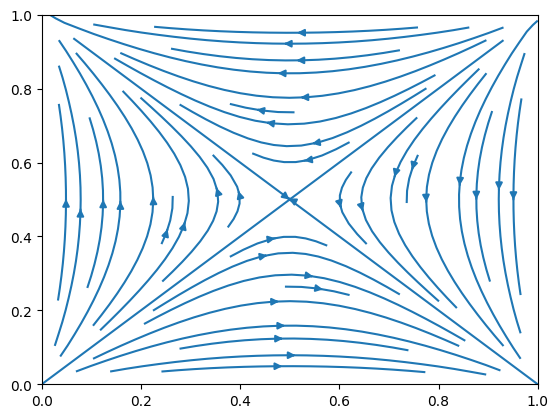

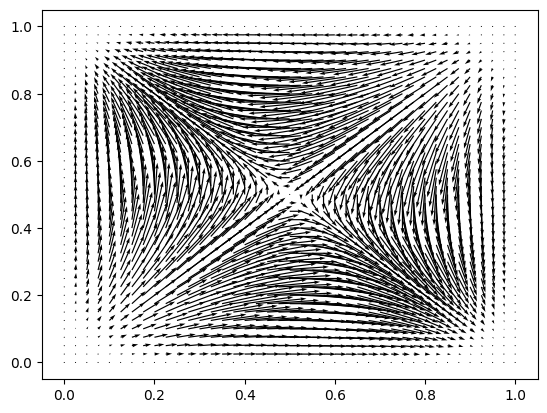

In [717]:
x_min = 0.0
x_max = 1.0
y_min = 0.0
y_max = 1.0

n_cells_x = 40  # Question's mesh
n_cells_y = 40  # Question's mesh

vertices, cells = generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y)

def u_1(x, y):
    return x**2 * ((1-x)**2) * (2*y-6*y**2+4*y**3)
def u_2(x, y):
    return y**2 * ((1-y)**2) *(2*x-6*x**2+4*x**3)
def p(x, y=0):
    return x*(1-x)

def calc_u_1(vertices):
    return u_1(vertices[:,0], vertices[:,1])
def calc_u_2(vertices):
    return u_2(vertices[:,0], vertices[:,1])
def calc_p(vertices):
    return p(vertices[:,0], vertices[:,1])

u_1_values = calc_u_1(vertices)
u_2_values = calc_u_2(vertices)
p_values = calc_p(vertices)

# Reshape vertices and values
x = vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1)
y = vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1)
u1 = u_1_values.reshape(n_cells_y+1, n_cells_x+1)
u2 = u_2_values.reshape(n_cells_y+1, n_cells_x+1)



#plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), p_values.reshape(n_cells_y+1, n_cells_x+1))  # plot the error
plt.streamplot(x, y, u1, u2)
plt.show()


# Create a quiver plot
plt.quiver(x, y, u1, u2, scale=0.1, scale_units='xy', angles='xy')

# Display the plot
plt.show()

In [718]:
def compute_local_mass_matrix():
    """Int_omega BiBk dx = Int_Omega BjBl dy; Multiply by h"""
    M_local = numpy.zeros([2, 2])
    M_local[0, 0] = 0.5
    M_local[1, 1] = 0.5
    
    return M_local

def compute_local_stiffness_matrix():
    """Int_omega Bix Bkx dx = Int_Omega Bjy Bly dy; Multiply by 1/h"""
    N_local = numpy.ones([2, 2])
    N_local[0, 1] = -1.0
    N_local[1, 0] = -1.0
    
    return N_local

def compute_local_advection_matrix():
    """Int_omega Bix Bk dx = Int_Omega Bjy Bl dy; Multiply by 1"""
    A_local = 0.5*numpy.ones([2, 2])
    A_local[0, 0] = -0.5
    A_local[1, 0] = -0.5
    
    return A_local

In [719]:
def compute_A1_and_A2_local():
    A1_A2 = numpy.zeros([4, 4])
    S_local_1D = compute_local_stiffness_matrix()
    M_local_1D = compute_local_mass_matrix()
    A1_A2 = numpy.kron(S_local_1D, M_local_1D) + numpy.kron(M_local_1D, S_local_1D)
    return A1_A2

def compute_G_local():
    G_local = numpy.zeros([4, 4])
    A_local = compute_local_advection_matrix()
    M_local = compute_local_mass_matrix()
    G_local = numpy.kron(A_local, M_local) + numpy.kron(A_local, M_local)
    return G_local

In [720]:
def compute_global_A_1_A_2(vertices, cells):

    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]

    N_row_idx = numpy.zeros([n_cells, 4, 4])
    N_col_idx = numpy.zeros([n_cells, 4, 4]) 
    N_data = numpy.zeros([n_cells, 4, 4])

    delta_x = (vertices[cells[:, 1], 0] - vertices[cells[:, 0], 0]).flatten()
    delta_y = (vertices[cells[:, 2], 1] - vertices[cells[:, 0], 1]).flatten()

    A1A2 = compute_A1_and_A2_local()
    
    for cell_idx, cell in enumerate(cells):
        col_idx, row_idx = numpy.meshgrid(cell, cell)
        N_row_idx[cell_idx, :, :] = row_idx
        N_col_idx[cell_idx, :, :] = col_idx

        N_data[cell_idx, :, :] = A1A2

    N_global = scipy.sparse.csr_array((N_data.flatten(), (N_row_idx.flatten(), N_col_idx.flatten())), shape=(n_vertices, n_vertices))
    A = scipy.sparse.bmat([[N_global, None], [None, N_global]])
    return A.tocsr(), N_global 

def compute_global_G(vertices, cells):


    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]

    N_row_idx = numpy.zeros([n_cells, 4, 4])
    N_col_idx = numpy.zeros([n_cells, 4, 4]) 
    N_data = numpy.zeros([n_cells, 4, 4])

    delta_x = (vertices[cells[:, 1], 0] - vertices[cells[:, 0], 0]).flatten()
    delta_y = (vertices[cells[:, 2], 1] - vertices[cells[:, 0], 1]).flatten()

    G_local = compute_G_local()
    
    for cell_idx, cell in enumerate(cells):
        col_idx, row_idx = numpy.meshgrid(cell, cell)
        N_row_idx[cell_idx, :, :] = row_idx
        N_col_idx[cell_idx, :, :] = col_idx

        N_data[cell_idx, :, :] = G_local * delta_x[cell_idx]

    G_1 = scipy.sparse.csr_array((N_data.flatten(), (N_row_idx.flatten(), N_col_idx.flatten())), shape=(n_vertices, n_vertices))

    for cell_idx, cell in enumerate(cells):
        col_idx, row_idx = numpy.meshgrid(cell, cell)
        N_row_idx[cell_idx, :, :] = row_idx
        N_col_idx[cell_idx, :, :] = col_idx

        N_data[cell_idx, :, :] = G_local * delta_y[cell_idx]
    G_2 = scipy.sparse.csr_array((N_data.flatten(), (N_row_idx.flatten(), N_col_idx.flatten())), shape=(n_vertices, n_vertices))

    G = scipy.sparse.bmat([[G_1], [G_2]])

    return G.tocsr(), G_1, G_2


def assemble_global_matrix(vertices, cells):
    print(vertices.shape)
    A = compute_global_A_1_A_2(vertices, cells)[0]
    G = compute_global_G(vertices, cells)[0]
    M = scipy.sparse.bmat([[A, -G], [G.T, None]])

    return M.tocsr()

In [721]:
f_1 = lambda x,y: -4 *(6* x**2 - 6* x + 1)* y* (2* y**2 - 3* y + 1) - 12* (1 - x)**2 *x**2* (-1 + 2* y) + 1-2 *x
f_2 = lambda x,y: 12* (2* x - 1) *(1 - y)**2* y**2 + 4* x *(1 - 3* x + 2* x**2)* (1 - 6 *y + 6 *y**2)
g = lambda x,y: 0
def compute_forcing_term_2D(f_1, f_2, g, vertices, cells):
    
    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = (vertices[cells[:, 1], 0] - vertices[cells[:, 0], 0]).flatten()
    delta_y = (vertices[cells[:, 2], 1] - vertices[cells[:, 0], 1]).flatten()
    
    F1 = numpy.zeros(n_vertices)
    F2 = numpy.zeros(n_vertices)
    F3 = numpy.zeros(n_vertices)
    for cell_idx, cell in enumerate(cells):
        f_at_cell_vertices = f_1(vertices[cell][:,0],vertices[cell][:,1])
        F1[cell] += 0.25 * f_at_cell_vertices * delta_x[cell_idx] * delta_y[cell_idx]

    for cell_idx, cell in enumerate(cells):
        f_at_cell_vertices = f_2(vertices[cell][:,0],vertices[cell][:,1])
        F2[cell] += 0.25 * f_at_cell_vertices * delta_x[cell_idx] * delta_y[cell_idx]

    for cell_idx, cell in enumerate(cells):
        f_at_cell_vertices = g(vertices[cell][:,0],vertices[cell][:,1])
        F3[cell] += 0.25 * f_at_cell_vertices * delta_x[cell_idx] * delta_y[cell_idx]

    
    return F1, F2, F3

In [730]:
def solve_Stokes(f_1, f_2, g, phi_left, phi_right, phi_bottom, phi_top, n_cells_x, n_cells_y, vertices, cells):

    #lhs
    S = assemble_global_matrix(vertices, cells)
    A, A1A2 = compute_global_A_1_A_2(vertices, cells)
    G, G1, G2 = compute_global_G(vertices, cells)

    #A = scipy.sparse.bmat([[A1A2, None], [None, A1A2]])
    #G = scipy.sparse.bmat([[G1], [G2]])
    #S = scipy.sparse.bmat([[A, -G], [G.T, None]]).tocsr()
    

    #rhs
    F1, F2, F3= compute_forcing_term_2D(f_1, f_2, g, vertices, cells)
    F = numpy.hstack([F1, F2, F3])
    multiplier = (n_cells_x + 1)*(n_cells_y + 1)
    print(multiplier)
    if False:
        # Include the boundary conditions
        # Left boundary
        i_idx = numpy.zeros(n_cells_y + 1, dtype=numpy.int64)
        j_idx = numpy.arange(0, n_cells_y + 1)
        left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
        S[left_basis_indices, :] = 0.0
        for basis_idx in left_basis_indices:
            S[basis_idx, basis_idx] = 1.0
            S[basis_idx, basis_idx] = 1.0
            S[basis_idx, basis_idx] = 1.0
            F[basis_idx] = phi_left  # note that phi_left is contant, if not, this needs to be changed  
        
        # Right boundary
        i_idx = n_cells_x*numpy.ones(n_cells_y + 1, dtype=numpy.int64)
        j_idx = numpy.arange(0, n_cells_y + 1)
        left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
        S[left_basis_indices, :] = 0.0
        for basis_idx in left_basis_indices:
            S[basis_idx, basis_idx] = 1.0
            F[basis_idx] = phi_right  # note that phi_right is contant, if not, this needs to be changed

        # Bottom boundary
        i_idx = numpy.arange(0, n_cells_x + 1)
        j_idx = numpy.zeros(n_cells_x + 1, dtype=numpy.int64)
        left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
        S[left_basis_indices, :] = 0.0
        for basis_idx in left_basis_indices:
            S[basis_idx, basis_idx] = 1.0
            F[basis_idx] = phi_bottom  # note that phi_bottom is contant, if not, this needs to be changed

        # Top boundary
        i_idx = numpy.arange(0, n_cells_x + 1)
        j_idx = n_cells_y*numpy.ones(n_cells_x + 1, dtype=numpy.int64)
        left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
        S[left_basis_indices, :] = 0.0
        for basis_idx in left_basis_indices:
            S[basis_idx, basis_idx] = 1.0
            F[basis_idx] = phi_top  # note that phi_top is contant, if not, this needs to be changed
    elif True:
        # Include the boundary conditions
        # Left boundary
        i_idx = numpy.zeros(n_cells_y + 1, dtype=numpy.int64)
        j_idx = numpy.arange(0, n_cells_y + 1)
        left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
        S[left_basis_indices, :] = 0.0
        for basis_idx in left_basis_indices:
            S[basis_idx, basis_idx] = 1.0
            S[basis_idx+multiplier, basis_idx+multiplier] = 1.0
            S[basis_idx+2*multiplier, basis_idx+2*multiplier] = 1.0
            F[basis_idx] = phi_left  # note that phi_left is contant, if not, this needs to be changed
            F[basis_idx+multiplier] = phi_left  # note that phi_left is contant, if not, this needs to be changed  
            F[basis_idx+2*multiplier] = phi_left  # note that phi_left is contant, if not, this needs to be changed  
            
        # Right boundary
        i_idx = n_cells_x*numpy.ones(n_cells_y + 1, dtype=numpy.int64)
        j_idx = numpy.arange(0, n_cells_y + 1)
        left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
        S[left_basis_indices, :] = 0.0
        for basis_idx in left_basis_indices:
            S[basis_idx, basis_idx] = 1.0
            S[basis_idx+multiplier, basis_idx+multiplier] = 1.0
            S[basis_idx+2*multiplier, basis_idx+2*multiplier] = 1.0
            F[basis_idx] = phi_right  # note that phi_right is contant, if not, this needs to be changed
            F[basis_idx+multiplier] = phi_right  # note that phi_right is contant, if not, this needs to be changed 
            F[basis_idx+2*multiplier] = phi_right  # note that phi_right is contant, if not, this needs to be changed  
            
        
        # Bottom boundary
        i_idx = numpy.arange(0, n_cells_x + 1)
        j_idx = numpy.zeros(n_cells_x + 1, dtype=numpy.int64)
        left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
        S[left_basis_indices, :] = 0.0
        print(left_basis_indices+multiplier)
        for basis_idx in left_basis_indices:
            S[basis_idx, basis_idx] = 1.0
            S[basis_idx+multiplier, basis_idx+multiplier] = 1.0
            S[basis_idx+2*multiplier, basis_idx+2*multiplier] = 1.0
            F[basis_idx] = phi_bottom  # note that phi_bottom is contant, if not, this needs to be changed
            F[basis_idx+multiplier] = phi_bottom  # note that phi_bottom is contant, if not, this needs to be changed  
            F[basis_idx+2*multiplier] = phi_bottom  # note that phi_bottom is contant, if not, this needs to be changed  

        # Top boundary
        i_idx = numpy.arange(0, n_cells_x + 1)
        j_idx = n_cells_y*numpy.ones(n_cells_x + 1, dtype=numpy.int64)
        left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
        
        S[left_basis_indices, :] = 0.0
        for basis_idx in left_basis_indices:
            S[basis_idx, basis_idx] = 1.0
            S[basis_idx +multiplier, basis_idx+multiplier] = 1.0
            S[basis_idx+2*multiplier, basis_idx+2*multiplier] = 1.0
            F[basis_idx] = phi_top  # note that phi_top is contant, if not, this needs to be changed
            print(basis_idx+multiplier)
            F[basis_idx+multiplier] = phi_top  # note that phi_top is contant, if not, this needs to be changed  
            F[basis_idx+2*multiplier] = phi_top  # note that phi_top is contant, if not, this needs to be changed
    else:
      # Include the boundary conditions
        # Left boundary
        i_idx = numpy.zeros(n_cells_y + 1, dtype=numpy.int64)
        j_idx = numpy.arange(0, n_cells_y + 1)
        left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
        A1A2[left_basis_indices, :] = 0.0
        G1[left_basis_indices, :] = 0.0
        G2[left_basis_indices, :] = 0.0
        for basis_idx in left_basis_indices:
            A1A2[basis_idx, basis_idx] = 1.0
            G1[basis_idx, basis_idx] = 1.0
            G2[basis_idx, basis_idx] = 1.0
            F1[basis_idx] = phi_left 
            F2[basis_idx] = phi_left  
            F3[basis_idx] = phi_left 
        
        # Right boundary
        i_idx = n_cells_x*numpy.ones(n_cells_y + 1, dtype=numpy.int64)
        j_idx = numpy.arange(0, n_cells_y + 1)
        left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
        A1A2[left_basis_indices, :] = 0.0
        G1[left_basis_indices, :] = 0.0
        G2[left_basis_indices, :] = 0.0
        for basis_idx in left_basis_indices:
            A1A2[basis_idx, basis_idx] = 1.0
            G1[basis_idx, basis_idx] = 1.0
            G2[basis_idx, basis_idx] = 1.0
            F1[basis_idx] = phi_right 
            F2[basis_idx] = phi_left  
            F3[basis_idx] = phi_left 

        # Bottom boundary
        i_idx = numpy.arange(0, n_cells_x + 1)
        j_idx = numpy.zeros(n_cells_x + 1, dtype=numpy.int64)
        left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
        A1A2[left_basis_indices, :] = 0.0
        G1[left_basis_indices, :] = 0.0
        G2[left_basis_indices, :] = 0.0
        for basis_idx in left_basis_indices:
            A1A2[basis_idx, basis_idx] = 1.0
            G1[basis_idx, basis_idx] = 1.0
            G2[basis_idx, basis_idx] = 1.0
            F1[basis_idx] = phi_left 
            F2[basis_idx] = phi_left  
            F3[basis_idx] = phi_left 

        # Top boundary
        i_idx = numpy.arange(0, n_cells_x + 1)
        j_idx = n_cells_y*numpy.ones(n_cells_x + 1, dtype=numpy.int64)
        left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
        A1A2[left_basis_indices, :] = 0.0
        G1[left_basis_indices, :] = 0.0
        G2[left_basis_indices, :] = 0.0
        for basis_idx in left_basis_indices:
            A1A2[basis_idx, basis_idx] = 1.0
            G1[basis_idx, basis_idx] = 1.0
            G2[basis_idx, basis_idx] = 1.0
            F1[basis_idx] = phi_left 
            F2[basis_idx] = phi_left  
            F3[basis_idx] = phi_left 

    Solution = scipy.sparse.linalg.spsolve(S, F)


    return Solution


(9, 2)


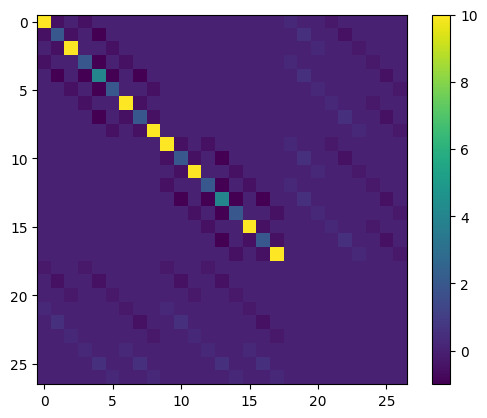

9
[ 9 10 11]
15
16
17


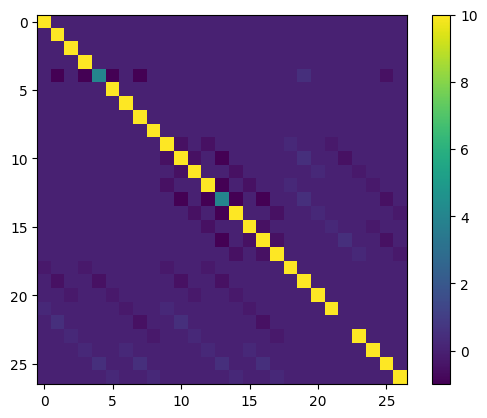

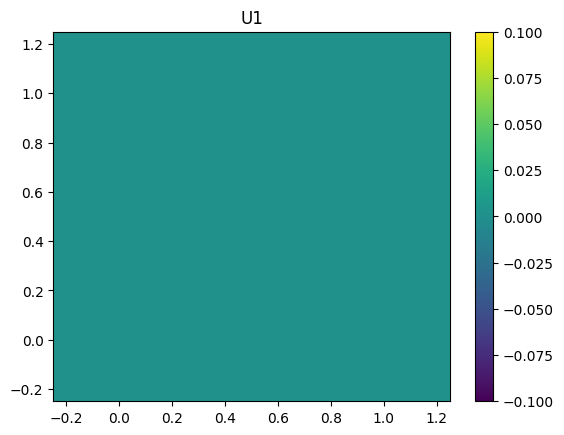

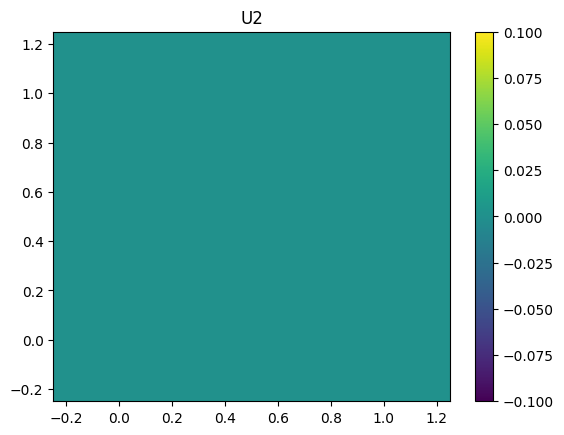

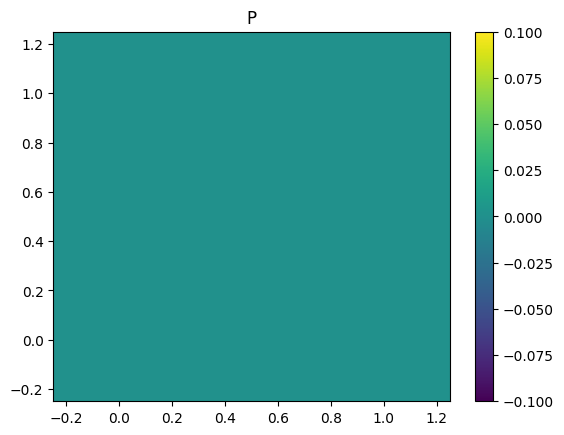

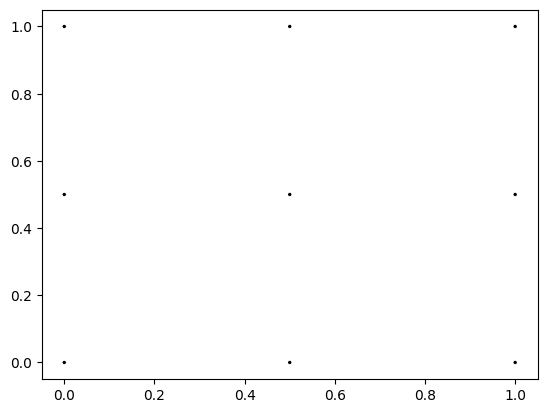

In [731]:
x_min = 0.0
x_max = 1.0
y_min = 0.0
y_max = 1.0

cellnr = 2


n_cells_x = cellnr  # Question's mesh
n_cells_y = cellnr  # Question's mesh

# Generate the meshes
vertices, cells = generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y)

phi_left = 0.0
phi_right = 0.0
phi_bottom = 0.0
phi_top = 0.0

u = solve_Stokes(f_1, f_2, g, phi_left, phi_right, phi_bottom, phi_top, n_cells_x, n_cells_y, vertices, cells)
u1 = u[:vertices.shape[0]]
u2 = u[vertices.shape[0]:2*vertices.shape[0]]
p = u[2*vertices.shape[0]:]
x = vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1)
y = vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1)
u1 = u1.reshape(n_cells_y+1, n_cells_x+1)
u2 = u2.reshape(n_cells_y+1, n_cells_x+1)
#plt.streamplot(x, y, u1, u2)

plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), u1.reshape(n_cells_y+1, n_cells_x+1))  # plot the error
plt.colorbar()
plt.title("U1")
plt.show()
plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), u2.reshape(n_cells_y+1, n_cells_x+1))  # plot the error
plt.colorbar()
plt.title("U2")
plt.show()
plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), p.reshape(n_cells_y+1, n_cells_x+1))  # plot the error
plt.colorbar()
plt.title("P")
plt.show()


plt.quiver(x, y, u1, u2, scale=0.1, scale_units='xy', angles='xy')
